<a href="https://colab.research.google.com/github/dqniellew1/DLPT/blob/master/Using_convolutions_to_generalize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
drive_dir = 'drive/My Drive/dlwpt-code/data/'

Taking a 1D view of our input image and multiplying it with a `n_output_features x n_input_features` weight matrix, as done in `nn.Linear`, means taking all pixels in the image, and for each channel computing a weighted sum of all pixels multiplied by a set of weights, one per output feature.

In [3]:
%matplotlib inline 
from matplotlib import pyplot as plt
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

In [3]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [4]:
from torchvision import datasets, transforms

data_path = '../data-unversioned/p1ch6/'
cifar10 = datasets.CIFAR10(data_path, train=True, download=True,
                           transform=transforms.Compose([
                                                         transforms.ToTensor(),
                                                         transforms.Normalize(
                                                             (0.4915, 0.4823, 0.4468),
                                                             (0.2470, 0.2435, 0.2616))
                                                         ]))

Extracting ../data-unversioned/p1ch6/cifar-10-python.tar.gz to ../data-unversioned/p1ch6/


In [5]:
cifar10_val = datasets.CIFAR10(data_path, train=False, download=False,
                               transform=transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Normalize((0.4915, 0.4823, 0.4468),
                                                   (0.2470, 0.2435, 0.2616))
                              ]))

In [6]:
label_map = {0:1, 2:1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label]) for img, label in cifar10 if label in [0, 2]]
cifar2_val = [(img, label_map[label]) for img, label in cifar10_val if label in [0, 2]]

# Convolutions

`nn.Conv1d` for time series, `nn.Conv2d` for images and `nn.Conv3d` for volumes or videos.

The arguments we provide to `nn.Conv2d` are the:
1. The number of input features (or channels, since we are dealing with so-called multi-channel images, i.e. more than one value per pixel)
2. The number of output features (arbitrary number, the more channels in the output image, the more the capacity of the network)
3. The size of the kernel


In [7]:
conv = nn.Conv2d(3, 16, kernel_size=3)
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

We expect the weight tensor to be sized `n_input_channels x 3 x 3 x n_output_channels`. The bias is just a constant value we add to each channel of the output image.

\* weights are initialized randomly

**As usual we need to add the zero-th batch dimension with unsqueeze** if we want to call the `conv` module with one input image. `nn.Conv2d` expects `B x C x H x W`.

In [8]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

In [9]:
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

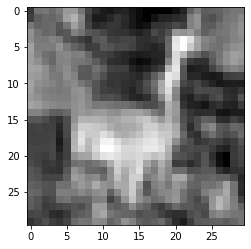

In [10]:
plt.imshow(output[0,0].detach(), cmap='gray')
plt.show()
# Bird after a random convolution treatment

The output size is slightly less because it is a side effect of deciding what to do at the boundary of the image.

To preserve image size, PyTorch gives us the possibility of padding the image, creating ghost pixels around the border that value zero as far as the convolution is concerned.

Specifying `padding=1` when `kernel_size=3` means that now `i00` has an extra set of neighbours above and left, so that an output of the convolution can be computed even in the corner of our original image.

In [11]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

\* the size of `weight` and `bias` dont change whether padding is used or not.

In [12]:
# play with convolution setting; weights by hand
with torch.no_grad():
  conv.bias.zero_() # zero out bias to remove any confounding factor

with torch.no_grad():
  conv.weight.fill_(1.0 / 9.0)

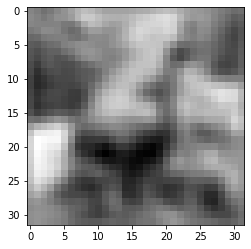

In [13]:
# See the results in the output image
output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()
# bird, this time blurred thanks to a constant convolution kernel.

Every pixel of the output is the average of a neighborhood of the input, so output pixels of the output will be correlated and change more smoothly.

In [14]:
# We can try something different
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)

with torch.no_grad():
  conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0]])
  conv.bias.zero_()

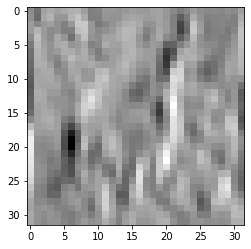

In [15]:
output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()
# Vertical edges throughout our bird because of hand-crafted kernel

## Depth and pooling

If we wish to downsample our image by half, we'll want to use a size of 2.

In [16]:
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))

img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

Proceed to building our convolutional neural network for detecting birds and planes.

In [17]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    nn.Conv2d(16, 8, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
)

Gone from 3 RGB channels to 16, thereby giving the network a chance to generate 16 independent features that will operate to hopefully discriminate low-level features of birds and airplanes. 

After the activation is applied, the 16-channel 32x32 image will be pooled to a 16-channel 16x16 image. 

At this point, the downsampled image will undergo another convolution that will generate a 8-channel 16x16 output, which again after the activation, will be pooled to a 8-channel 8x8 output.

After the input image has been reduced to a set of 8x8 features, we expect some output of probabilities, so that we can feed our negative log likelihood. 

However, probabilities are a pair of numbers in a 1D vector (1 for bird, 1 for airplane, while we are still dealing with multi-channel 2D features.

In [18]:
# Turn our 8-channel 8x8 image into a 1D vector 
# Complete our network with a set of fully connected layers.
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    nn.Conv2d(16, 8, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    # ... Missing something important?
    nn.Linear(8 * 8 * 8, 32),
    nn.Tanh(),
    nn.Linear(32, 2))
# Linear layer is dependent on the expected size of the MaxPool2d output
# i.e. 8 * 8 * 8 = 512

In [19]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

Reasonable! In order to increase the capacity of the model, we could
1. increase the number of output channels for the conv layers (which would lead to the linear layer increasing in size as well)

In [20]:
model(img.unsqueeze(0))

RuntimeError: ignored

What is missing there is the **reshaping step** from a 8-channel 8x8 image to a 512-element, 1D vector.

We could use `view` on the output of the last `nn.MaxPool2d` but we dont have visibility of output of each module when we use `nn.Sequential`.

# Subclassing nn.Module

we need some flexibility therefore we need to subclass. In order to subclass, at the minimum we need to define the `forward` function

In [21]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
    self.act1 = nn.Tanh()
    self.pool1 = nn.MaxPool2d(2)
    self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
    self.act2 = nn.Tanh()
    self.pool2 = nn.MaxPool2d(2)
    self.fc1 = nn.Linear(8 * 8 * 8, 32)
    self.act3 = nn.Tanh()
    self.fc2 = nn.Linear(32, 2)

  def forward(self, x):
    out = self.pool1(self.act1(self.conv1(x)))
    out = self.pool2(self.act2(self.conv2(out)))
    out = self.view(-1, 8 * 8 * 8) # The reshape. we have been missing
    out = self.act3(self.fc1(out))
    out = self.fc2(out)
    return out

This `Net` class is equivalent to the `nn.Sequential` model we build in terms of submodules, by writing the `forward` function explicitly, we were able to manipulate the output of `self.pool3` directly and call `view` om it to turn it into a BxN vector. Note that we leave the batch dimension as -1 in the call to view, since in principle we don't know how many samples there'll be in the batch.

In [22]:
model = Net()

In [23]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

It would appear as a waste to be registering submodules with no parameters such as `nn.Tanh` and `nn.MaxPool2d`. We can call those in the `forward` function. PyToch has functional counterparts for every `nn` module. "Functional" meaning no internal state or whose output value is solely and fully determined by the value input arguments.

In [24]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
    self.fc1 = nn.Linear(8 * 8 * 8, 32)
    self.fc2 = nn.Linear(32, 2)

  def forward(self, x):
    out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
    out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
    out = out.view(-1, 8 * 8 * 8)
    out = torch.tanh(self.fc1(out))
    out = self.fc2(out)
    return out

In [25]:
model = Net()
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [26]:
# Double check our model runs
model(img.unsqueeze(0))

tensor([[0.0234, 0.0825]], grad_fn=<AddmmBackward>)

We've got 2 numbers out! Information flows correctly. 

# Training our Convnet

In [30]:
# Writing the training loop
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
  for epoch in range(1, n_epochs + 1):
    loss_train = 0.0
    for imgs, labels in train_loader:
      outputs = model(imgs)
      loss = loss_fn(outputs, labels)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      loss_train += loss.item()

    if epoch == 1 or epoch % 10 == 0:
      print('{} Epoch {}, Training loss {}'.format(
          datetime.datetime.now(), epoch, float(loss_train)))


In [32]:
# Train our model
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

model = Net()
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer, 
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2020-06-25 21:50:56.575635 Epoch 1, Training loss 20.153247013688087
2020-06-25 21:51:23.489326 Epoch 10, Training loss 0.20436260174028575
2020-06-25 21:51:53.067695 Epoch 20, Training loss 0.09466910781338811
2020-06-25 21:52:23.560837 Epoch 30, Training loss 0.061047998431604356
2020-06-25 21:52:53.961979 Epoch 40, Training loss 0.04488775183563121
2020-06-25 21:53:24.210653 Epoch 50, Training loss 0.03542189617292024
2020-06-25 21:53:54.667978 Epoch 60, Training loss 0.029206678955233656
2020-06-25 21:54:24.913268 Epoch 70, Training loss 0.02482855212292634
2020-06-25 21:54:55.132774 Epoch 80, Training loss 0.02158727651112713
2020-06-25 21:55:25.467548 Epoch 90, Training loss 0.01907383670913987
2020-06-25 21:55:55.618672 Epoch 100, Training loss 0.017078559605579358


In [35]:
# Look at accuracies on the training and val sets
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

for loader in [train_loader, val_loader]:
  correct = 0
  total = 0

  with torch.no_grad():
    for imgs, labels in loader:
      outputs = model(imgs)
      _, predicted = torch.max(outputs, dim=1) # This will give us the index of the highest value in output
      total += labels.shape[0]
      correct += int((predicted == labels).sum())

  print("Accuracy: %f"% (correct / total))

Accuracy: 1.000000
Accuracy: 1.000000


In [36]:
torch.save(model.state_dict(), data_path + 'birds_vs_planes.pt')

The `birds_vs_planes.pt` file now contains all the parametes of the `model`, that is weights and biases for the two convolution modules and the two linear modules.

So, no structure, just the weights. This means that when we deploy the model in production for our friend, we'll need to keep the model class handy, create an instance and then load parameters back into it:

In [40]:
loaded_model = Net()
loaded_model.load_state_dict(torch.load('./data-unversioned/p1ch6/birds_vs_planes.pt'))

<All keys matched successfully>

# Implementing fundamentals

## Width

Width of the network, that is the number of neurons per layer, or channels per convolution

We can make our model wider very easily.

**We just specify a larger number of output channels in the first convolution, and increase the subsequent layers accordingly**

In [4]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
    self.fc1 = nn.Linear(8 * 8 * 16, 32)
    self.fc2 = nn.Linear(32, 2)

  def forward(self, x):
    out = F.maxpool2d(torch.tanh(self.conv1(x)), 2)
    out = F.maxpool2d(torch.tanh(self.conv2(out)),2)
    out = out.view(-1, 8 * 8 * 16)
    out = torch.tanh(self.fc1(out))
    out = self.fc2(out)
    return out

If we want to avoid hard-coding numbers in the definition of the model, we can easily **pass a parameter to `init` and parameterize width, taking care to also parameterize the call to `view` in the forward function**.

In [5]:
class Net(nn.Module):
  def __init__(self, n_chans1=32):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1) # floor division
    self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
    self.fc2 = nn.Linear(32, 2)

  def forward(self, x):
    out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
    out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
    out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
    out = torch.tanh(self.fc1(out))
    out = self.fc2(out)
    return out

model = Net(n_chans1=32)
